In [30]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation

# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

In [2]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [3]:
# append in ONE data
data=train.append(test)

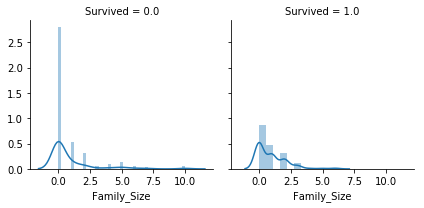

In [4]:
data['Family_Size']=data['Parch']+data['SibSp']
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [5]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
data['Title1'].head(10)
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
data['Title1'].head(10)
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [7]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [9]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})

In [10]:
tt['PassengerId'].describe()

count     37.000000
mean      35.378378
std      156.804434
min        1.000000
25%        1.000000
50%        4.000000
75%        9.000000
max      957.000000
Name: PassengerId, dtype: float64

In [11]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<9]='None'
tt.head(4)

,Ticket_info,PassengerId,Ticket_info_rev
0,A,1,None
1,A4,10,A4
2,A5,28,A5
3,AQ3,1,None


In [12]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,Mr,A5,A5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,Mrs,Mrs,PC,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,Miss,Mr,STONO2,None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,Mrs,Mr,X,X


In [13]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [14]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

"\ndata['Cabin_info2']=data['Cabin_info']\ndata.Cabin_info2[data.Cabin_info in ('N','C')]='mm'\ndata.head()"

In [15]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [16]:
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

In [17]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [18]:
#
print('Age遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
data['Age']=data['Age'].fillna(data['Age'].median())

Age遺漏的人數： 263


In [19]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info_rev,Cabin_info
0,22.0,S,7.2500,0,1,3,male,1,0.0,1,Mr,A5,N
1,38.0,C,71.2833,0,2,1,female,1,1.0,1,Mrs,PC,C
2,26.0,S,7.9250,0,3,3,female,0,1.0,0,Mr,None,N


In [20]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,Embarked_C,Embarked_Q,...,Ticket_info_rev_STONO,Ticket_info_rev_WC,Ticket_info_rev_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
data_dummies.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ',
       'Ticket_info_rev_STONO', 'Ticket_info_rev_WC', 'Ticket_info_rev_X',
       'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D',
       'Cabin_info_E', 'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [22]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

"\ndata['Sex'] = data['Sex'].astype('category').cat.codes\ndata['Embarked'] = data['Embarked'].astype('category').cat.codes\ndata['Pclass'] = data['Pclass'].astype('category').cat.codes\ndata['Title2'] = data['Title2'].astype('category').cat.codes\ndata['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes\ndata['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes\ndata.head(4)\n"

In [41]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass','Survived', 'SibSp',
       'Family_Size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master'
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC'
       'Ticket_info_rev_STONO', 'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
dataTest = dataTest[['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp',
       'Family_Size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master'
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC'
       'Ticket_info_rev_STONO', 'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]

In [28]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [31]:
# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTrain)
X = dataTrain.drop('Survived', axis=1)
y = dataTrain.Survived

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [32]:
#bayesian-optimization
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [33]:
#Step 2: Set the range for each parameter (make the range as narrow as possible)
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (40, 50),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

In [34]:
# ### Put all together
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, max_bin):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin'] = int(round(max_bin))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.1, 0.9),
                                            'max_depth': (5, 9),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (2, 5),
                                            'min_split_gain': (0.03, 0.08),
                                            'min_child_weight': (5, 50),
                                           'max_bin': (4, 10)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [35]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)
print(opt_params)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
    1 | 00m00s |    0.83972 |             0.7334 |             0.6167 |      4.8931 |      3.9198 |    6.1570 |      5.3485 |            32.7936 |           0.0432 |      35.5251 | 
    2 | 00m00s |    0.84084 |             0.5231 |             0.4501 |      3.9958 |      2.4301 |    6.6222 |      5.0809 |            32.5443 |           0.0687 |      39.0190 | 
    3 | 00m00s |    0.83836 |             0.5544 |             0.8134 |      2.3074 |      4.8340 |    8.1858 |      8.3305 |            32.7620 |           0.0528 |      36.6580 | 
    4 | 00m00s |    0.83065 |             0.8405 |             0.8709 |     

In [36]:
# LGBM with Bayesian Optimization
LGBM_bayes = LGBMClassifier(
    num_leaves=38,
    feature_fraction = 0.8207778100863264,
    bagging_fraction = 0.7123048432060056,
    max_depth=5,
    lambda_l1 = 0.25455982737410454,
    lambda_l2 = 2.124722521464596,
    min_split_gain=0.06751056206031258,
    min_child_weight=5,
    max_bin = 10,
    random_state=0, 
    n_estimators=1000, 
    learning_rate=0.05,
    application = 'binary',
    num_iterations = 10000, 
    early_stopping_round = 100, 
    metric = 'auc'
  )



LGBM_bayes_fit = LGBM_bayes.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.922585	valid_1's auc: 0.822516
[200]	training's auc: 0.939025	valid_1's auc: 0.824834
Early stopping, best iteration is:
[195]	training's auc: 0.938561	valid_1's auc: 0.825177


Accuracy:0.772
Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82       156
        1.0       0.78      0.63      0.70       112

avg / total       0.77      0.77      0.77       268

Confusion matrix
[[136  20]
 [ 41  71]]
ROC AUC Score
0.8251774267399268
Feature importances: [328, 271, 39, 270, 142, 24, 88, 56, 0, 40, 100, 27, 1, 1, 17, 0, 26, 0, 72]
Plot feature importances...


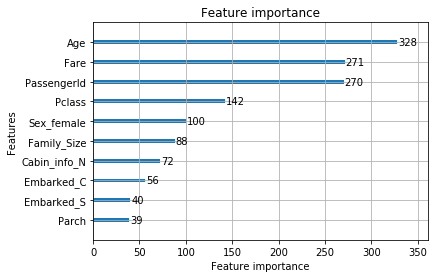

In [37]:
# measure performance
LGBM_bayes_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_bayes, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True)

# feature importances
print('Feature importances:', list(LGBM_bayes.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_bayes_fit, max_num_features=10)
plt.show()

In [42]:
#predict Test data
#submit the data to kaggle
LGBM_bayes_fit_res =LGBM_bayes_fit.predict(dataTest)
submit['Survived'] = LGBM_bayes_fit_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [43]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [43]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.0.79425")

一樣的x去做
CART:Your submission scored 0.74641
RF:Your submission scored 0.76076
GBDT:Your submission scored 0.77511
RF(18個X):Your submission scored 0.0.79425


#### Important Features Using Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [40]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [41]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp

,importances,features
0,0.1538,PassengerId
1,0.1390,Fare
2,0.1384,Age
3,0.1247,Sex_female
4,0.1228,Sex_male
5,0.0618,Pclass
6,0.0459,Family_Size
7,0.0306,Cabin_info_N
8,0.0302,SibSp
9,0.0269,Title2_Mr
